<a href="https://colab.research.google.com/github/AnIsAsPe/Named-Entity-Recognition-NER-con-LSTM-Bidireccionales/blob/main/Notebooks/Reconocimiento_de_Entidades_Nombradas_mediante_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> RECONOCIMIENTIO DE ENTIDADES NOMBRADAS

(NER, Named-Entity-Recognition) 

IMPORTANTE: Cambiar el entorno de ejecución para trabajar con GPU

# 1. Cargar bibliotecas 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim  # para cargar modelo w2v
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model


# 2.Leer Datos

In [2]:
csv_file ="https://raw.githubusercontent.com/AnIsAsPe/Named-Entity-Recognition-NER-con-LSTM-Bidireccionales/main/Datos/ner_datasetreference.csv"
data = pd.read_csv(csv_file, encoding= 'unicode_escape', usecols =[0,1,3])
data = data.fillna( method='ffill', axis=0)  # copia en los NaN la última observación válida, hasta encontrar la siguiente. 
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [ ]:
data.nunique()  # Valores únicos en cada columna

Sentence #    47959
Word          35178
Tag              17
dtype: int64

In [4]:
# promedio de palabras por sentencia 
data.shape[0]/data['Sentence #'].nunique()

21.863987989741236

In [5]:
data.Tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

* geo - Geographical Entity
* gpe - Geopolitical Entity
* per - Person
* org - Organization
* tim - Time indicator
* art - Artifact
* eve - Event
* nat - NaturalPhenomenon

[Inside-Outside-Beginning (tagging)](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) 

# 3.Identificar cada token y cada etiqueta con un valor numérico

In [6]:
def get_dict_map(data, token_or_tag):    
    if token_or_tag == 'token':
        # agregamos 'PAD_token' al vocabulario de tokens, para ser usado más
        # adelante a fin de que todas las oraciones tengan la misma cantidad de 
        # tokens
        vocab = ['PAD_token'] + list(data.Word.unique()) 
    elif token_or_tag == 'tag':
        vocab = list(data.Tag.unique())
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [7]:
tag2idx

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [8]:
n_tags = len(tag2idx)
n_tags

17

In [9]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx) 
data.head()

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,O,1,0
1,Sentence: 1,of,O,2,0
2,Sentence: 1,demonstrators,O,3,0
3,Sentence: 1,have,O,4,0
4,Sentence: 1,marched,O,5,0


# 4.Obtener la matriz de vectores para todas las palabras del vocabulario 

<h2> Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3 millones de palabras y frases en inglés. 
Crea un acceso directo en tu drive del modelo preentrenado que está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Si es la primera vez que corres el notebook, descomenta las siguientes lineas para cargar el modelo preentrenado completo. 

In [ ]:
# %%time
# # asegurate de poner la ruta correcta en donde se ubica el archivo en tu drive
# file =  '/content/drive/MyDrive/Embeddings/GoogleNews-vectors-negative300.bin.gz'  
# w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

CPU times: user 1min 58s, sys: 3.68 s, total: 2min 2s
Wall time: 2min 10s


In [ ]:
# print('Palabras en el modelo w2v: {:,} '.format(len(w2v.vocab)))
# print('Dimensiones por embedding: ', w2v.vector_size)

Palabras en el modelo w2v: 3,000,000 
Dimensiones por embedding:  300


<h3> Reducción del diccionario de embeddings para tener solo los tokens presentes en nuestro corpus.

Guardar en pikle
Así no tendremos que volver a cargar todo el modelo word embedding

In [ ]:
# dic_tokens_word2vec  = {}
# palabras_sin_embedding =[]
# for token in data.Word.unique():
#   try:
#     dic_tokens_word2vec[token] = w2v[token]
#   except:
#     palabras_sin_embedding.append(token)

In [ ]:
# import pickle
# path = '/content/drive/MyDrive/Pikles'
# pickle.dump(dic_tokens_word2vec, open (path + "dic_tokens_ner_w2v.pkl", 'wb'))

In [11]:
import pickle
path = '/content/drive/MyDrive/Pikles'
dic_tokens_word2vec = pickle.load(open(path + "dic_tokens_ner_w2v.pkl", 'rb'))

In [12]:
palabras_sin_embedding = [tok for tok in data.Word.unique() if tok not in dic_tokens_word2vec.keys()]


In [13]:
len(palabras_sin_embedding)

6276

In [14]:
# Tokens más frecuentes sin embbedding en nuestros datos.
data[data.Word.isin(palabras_sin_embedding)]['Word'].value_counts().head(30)

.           47761
,           32754
of          26354
to          23213
a           20481
and         19936
's          10923
"            3686
-            1172
)             665
(             664
10            432
'             415
al-Qaida      398
2003          343
20            327
30            288
15            285
11            266
2008          248
2004          241
2001          233
12            230
U.S.-led      223
2010          218
H5N1          215
50            212
;             208
2006          208
2009          208
Name: Word, dtype: int64

In [15]:
# número de palabras del vocabulario encontradas en el modelo word2vec
len(data[data.Word.isin(dic_tokens_word2vec)]['Word'].unique())

28902

In [16]:
num_tokens = len(token2idx)
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for token, i in token2idx.items():
    if token in dic_tokens_word2vec.keys():
       embedding_matrix[i] = dic_tokens_word2vec[token]
        

In [17]:
data.Word.nunique()

35178

In [18]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.060547,0.131836,-0.083008,0.294922,-0.296875,-0.050537,-0.328125,0.025635,0.041260,0.250000,...,-0.189453,-0.390625,-0.347656,0.110840,0.209961,-0.156250,-0.215820,0.239258,0.016235,0.104980
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.094727,0.127930,0.050049,0.247070,0.246094,-0.279297,-0.263672,0.020386,-0.228516,0.163086,...,0.029419,-0.261719,-0.115723,-0.117676,0.227539,0.369141,-0.015625,-0.228516,0.196289,0.140625
4,-0.139648,-0.034668,-0.053711,0.179688,-0.036865,-0.025757,0.004852,-0.083496,0.008179,0.324219,...,-0.049072,0.063477,0.080566,0.088867,0.077637,-0.046631,-0.071777,-0.118164,-0.002457,-0.072266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35174,0.221680,0.168945,0.061035,0.121094,-0.052734,-0.022705,-0.117676,-0.250000,-0.084961,-0.170898,...,-0.013489,0.103516,-0.006866,0.036865,0.237305,-0.335938,-0.067383,-0.038086,0.233398,0.084961
35175,0.351562,0.126953,0.246094,0.275391,-0.005493,0.090820,-0.241211,0.049316,0.128906,0.215820,...,-0.147461,0.008728,-0.047363,-0.006042,-0.042236,-0.034668,-0.133789,-0.100098,0.077148,0.457031
35176,-0.527344,0.086426,-0.035400,0.003342,-0.003418,0.086914,0.199219,-0.152344,0.247070,0.158203,...,-0.332031,0.141602,0.033447,0.006104,0.240234,-0.005829,-0.159180,-0.169922,0.054932,-0.233398
35177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 5.Preparar las secuencias que ingresarán a nuestra red neuronal.


## 5.1.Pasar de tokens por renglón a la secuencia completa de la oración por renglón.

In [19]:
sentences = data.groupby(['Sentence #'], as_index=False ).agg(lambda x: list(x))

sentences.head(5)

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[125, 126, 127, 128, 129, 8, 130, 131, 8, 132,...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[943, 944, 364, 945, 345, 946, 12, 10, 947, 24...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[43, 847, 134, 46, 4646, 4647, 4648, 32, 1879,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[155, 837, 1189, 7564, 9399, 173, 351, 94, 150...","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,..."


## 5.2 Unificar el tamaño de las secuencias (pad sequences)

Padding: Las capas de LSTM necesitan que cada secuencias (oración) tenga la misma longitud, se puede usar cualquier longitud, pero entre más grande sea mayor será el costo del entrenamiento.

Las oraciones  que sean más cortas se "rellenaran" con el token que agregamos anterioremente ('PAD_token')


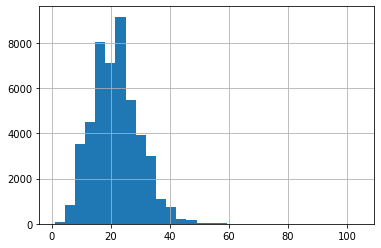

La oración más larga tiene 104 tokens


In [20]:
sentences['Word'].str.len().hist(bins=30)
plt.show()
print('La oración más larga tiene {} tokens'.format(sentences['Word'].str.len().max()))

In [21]:
max_len = int(sentences['Word'].str.len().quantile(0.9975))
max_len

50

In [22]:
pad_tokens = pad_sequences(sentences['Word_idx'], maxlen=max_len, 
                           dtype='int32', padding='post',
                           value = token2idx['PAD_token'])
pad_tags = pad_sequences(sentences['Tag_idx'], maxlen=max_len,
                         dtype='int32', padding='post',
                         value= tag2idx["O"])  

pad_tags = [to_categorical(i, num_classes=len(tag2idx)) for i in pad_tags] 

In [23]:
print(sentences.loc[13, 'Word'])
print(sentences.loc[13, 'Word_idx'])
print(sentences.loc[13, 'Tag'])
print(sentences.loc[13, 'Tag_idx'])

['Syria', 'is', 'widely', 'accused', 'of', 'involvement', 'in', 'his', 'killing', ',', 'and', 'Friday', "'s", 'explosion', 'comes', 'days', 'before', 'U.N.', 'investigator', 'Detlev', 'Mehlis', 'is', 'to', 'return', 'to', 'Damascus', 'to', 'interview', 'several', 'Syrian', 'officials', 'about', 'the', 'assassination', '.']
[4494, 79, 1182, 828, 2, 4495, 12, 497, 1778, 94, 14, 366, 69, 2599, 63, 975, 447, 155, 9855, 12597, 12598, 79, 8, 2385, 8, 4493, 8, 1471, 643, 3772, 126, 731, 10, 1277, 22]
['B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-per', 'I-per', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 3, 10, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0]


In [24]:
pad_tokens[13]

array([ 4494,    79,  1182,   828,     2,  4495,    12,   497,  1778,
          94,    14,   366,    69,  2599,    63,   975,   447,   155,
        9855, 12597, 12598,    79,     8,  2385,     8,  4493,     8,
        1471,   643,  3772,   126,   731,    10,  1277,    22,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [25]:
for token, tag in zip(pad_tokens[13], pad_tags[13]):
    print('%s\t%s' % (token, tag))

4494	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
79	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1182	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
828	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4495	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
497	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1778	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
94	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
14	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
366	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
69	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2599	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
63	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
975	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
447	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
155	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

# 6.Dividir en conjunto de entrenamiento y prueba

In [26]:
train_tokens, test_tokens, train_tags, test_tags = train_test_split(
pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

print(
'train_tokens:', len(train_tokens),
'\ntrain_tags:', len(train_tags),
'\ntest_tokens:', len(test_tokens),
'\ntest_tags:', len(test_tags)
)

train_tokens: 43163 
train_tags: 43163 
test_tokens: 4796 
test_tags: 4796


# 7.Construcción de la Arquitectura del Modelo


- **Embedding layer** : Será la primera capa de nuestro modelo en el que ingresaremos las secuencias todas de tamaño 50. Esta capa no la entrenaremos (training = False), sino que en su lugar la alimetaremos con la matriz de embedings que preparamos en el paso 4. La salida de esa capa será un tensor de tres dimensiones para alimentar a la capa LSTM [Bath size, timesteps, features] que en nuestro caso se traducirá en [None, 50, 300]

- **Bidirectional LSTM** : Tomará la salida de la capa de embedings y concatenará las salidas de las dos direcciones del LSTM, cada salida tendra las unidades que se declaren en la capa LSTM (128) y al concatenarse, la salida será del doble de unidades (None, 54, 256) 

- **TimeDistributed  Layer** : La arquitectura de nuestra RNN es de tipo muchas a muchas, en donde para cada token (timestep) de la secuencia de entrada, esperamos la probabilidad de pertenencia a cada  una de las clases. Para ello se usa esta capa activada por la función 'Softmax'. La salida de esta capa será un tensor de (None, 50, 17)

In [27]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [28]:
input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,  
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable=False)(input)
# Capa 1 LSTM Bidireccional
LSTM_Bi = Bidirectional(LSTM(units=128,
                             return_sequences=True, # Todos los estados h para cada timestep
                             recurrent_dropout=0.2, dropout=0.2  # Para evitar sobreajuste
                             ))(embedding)
# Capa de Salida
out = TimeDistributed(Dense(n_tags, # 17 (las clases de los Tags)
                            activation="softmax"  # para obtener una probabilidad para cada clase
                            ))(LSTM_Bi)   

NER_model = Model(input, out)  # unión del modelo
NER_model.summary()  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           10553700  
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          439296    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           4369      
 ibuted)                                                         
                                                                 
Total params: 10,997,365
Trainable params: 443,665
Non-trainable params: 10,553,700
_________________________________________________________________


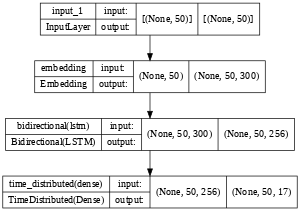

In [29]:
plot_model( 
    NER_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

# 8.Entrenamiento del modelo

In [30]:
# Compile model
NER_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [31]:
history = NER_model.fit(train_tokens, np.array(train_tags), validation_split=0.2,
                    batch_size=200, epochs=5, verbose=1)

Epoch 1/5
173/173 [==============================] - 74s 382ms/step - loss: 0.3575 - accuracy: 0.9417 - val_loss: 0.1218 - val_accuracy: 0.9701
Epoch 2/5
173/173 [==============================] - 68s 389ms/step - loss: 0.1058 - accuracy: 0.9729 - val_loss: 0.0924 - val_accuracy: 0.9754
Epoch 3/5
173/173 [==============================] - 63s 367ms/step - loss: 0.0868 - accuracy: 0.9766 - val_loss: 0.0797 - val_accuracy: 0.9778
Epoch 4/5
173/173 [==============================] - 65s 374ms/step - loss: 0.0772 - accuracy: 0.9786 - val_loss: 0.0731 - val_accuracy: 0.9794
Epoch 5/5
173/173 [==============================] - 64s 369ms/step - loss: 0.0711 - accuracy: 0.9797 - val_loss: 0.0677 - val_accuracy: 0.9803


In [41]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
NER_model.save_weights('/content/drive/MyDrive/Modelos/Weights_NER_jul22')

In [42]:
# Leer el modelo guardado
NER_model.load_weights('/content/drive/MyDrive/Modelos/Weights_NER_jul22')

# 9.Predicción y Evaluación

In [32]:
test_pred = NER_model.predict(np.array(test_tokens), verbose=1)

150/150 [==============================] - 4s 26ms/step


In [33]:
test_pred.shape

(4796, 50, 17)

In [34]:
pd.DataFrame(test_pred[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.993407,0.000247,3.878115e-05,1.280404e-04,9.144639e-05,0.000247,9.879643e-05,0.004012,8.255625e-05,9.128919e-05,8.767625e-05,3.078912e-05,1.080691e-03,1.240337e-04,7.738981e-05,1.283139e-04,2.593158e-05
1,0.820237,0.001609,8.280577e-05,5.407893e-04,1.200599e-04,0.000264,5.975156e-05,0.147497,2.505034e-04,1.506271e-04,1.844551e-04,8.784736e-05,2.791766e-02,3.116929e-04,2.482074e-04,3.925199e-04,4.590845e-05
2,0.409009,0.012789,4.352765e-04,1.516819e-03,1.312042e-03,0.004353,5.072458e-04,0.444013,9.007344e-04,5.433526e-04,7.791365e-04,3.623936e-04,1.199360e-01,8.455221e-04,1.259214e-03,1.316747e-03,1.212518e-04
3,0.844993,0.043331,5.405994e-04,1.382292e-03,2.524532e-03,0.006160,1.358281e-03,0.056741,7.451749e-04,4.410306e-04,6.656297e-04,4.176352e-04,3.864660e-02,6.117218e-04,7.339811e-04,6.351904e-04,7.289171e-05
4,0.006535,0.924929,2.642780e-02,8.417222e-04,2.343557e-02,0.012173,7.645047e-04,0.001329,3.962381e-04,1.510085e-04,2.555376e-04,1.257578e-03,6.570263e-04,3.184379e-04,3.667191e-04,1.117388e-04,4.992152e-05
5,0.999916,0.000005,2.576838e-06,8.300181e-07,4.141250e-06,0.000002,3.234268e-06,0.000022,1.642894e-06,1.283078e-06,2.367342e-06,8.251997e-07,3.060904e-05,2.972560e-06,1.175111e-06,2.134318e-06,3.715740e-07
6,0.999545,0.000205,1.633494e-06,2.170106e-06,1.381823e-06,0.000095,1.967114e-06,0.000099,6.495507e-06,1.523467e-06,1.421165e-07,4.656843e-07,3.157216e-05,4.672452e-06,2.712040e-06,1.789405e-06,2.827073e-07
7,0.999611,0.000040,5.372336e-06,6.125315e-06,9.835795e-07,0.000046,2.510791e-06,0.000184,8.294186e-06,1.975279e-06,2.490272e-07,9.094888e-07,7.514287e-05,9.159112e-06,4.589054e-06,2.840030e-06,4.857889e-07
8,0.999686,0.000051,9.302453e-07,1.712689e-06,4.998756e-07,0.000058,1.943476e-06,0.000094,8.534680e-06,1.744629e-06,1.410167e-07,3.288453e-07,7.929607e-05,9.406369e-06,3.740681e-06,2.387789e-06,3.494557e-07
9,0.997601,0.000210,3.854236e-06,1.164911e-05,1.916172e-05,0.000124,1.356880e-05,0.001116,5.543829e-05,1.802050e-05,1.923790e-06,2.065571e-06,6.015508e-04,1.553436e-04,3.495132e-05,2.338755e-05,6.807184e-06


In [35]:
test_tokens[0:2]

array([[ 346, 1063, 3223,   94, 1953, 8511,  121,  714, 1990, 3996,   12,
        4105,   94,   32, 5239, 3603,    8, 7898, 1344, 4180, 2231,   22,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 368,  369,  569,  503, 2659,   10, 9448,  539,    8, 2385,    8,
         497, 1071,   12, 9465,   94,   12,  309, 2569,   94,   12,   46,
         105,  281,  981,   22,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [36]:
 test_tokens[0,1]

1063

In [37]:
def secIdx2secTok(M):
  n = M.shape[0]
  d = M.shape[1]
  oraciones = []
  for i in range(n):
      tokens = []
      for j in range(d):
          idx = M[i, j]
          tokens.append(idx2token[idx])
      oraciones.append(tokens)
  return oraciones

test_toks = secIdx2secTok(test_tokens)


In [38]:

def secIdx2secTag(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out


    
pred_labels = secIdx2secTag(test_pred)
test_labels = secIdx2secTag(test_tags)

In [39]:
dfs = {}
for idx in range(len(test_labels)):
  dfs[idx] = pd.DataFrame({'sent_idx': idx, 'Word': test_toks[idx],
                           'Pred':pred_labels[idx], 'Tag':test_labels[idx]})

resultados = pd.concat(dfs, ignore_index = True).set_index('sent_idx')
resultados = resultados[resultados['Word']!='PAD_token']
resultados['acierto'] = np.where(resultados['Pred']==resultados['Tag'],1,0)
resultados['acierto'].mean()

0.9547780749177521

In [40]:
resultados.loc[54]  # 4 , 8 , 87

,Word,Pred,Tag,acierto
sent_idx,,,,
54,The,O,O,1
54,U.S.,B-geo,B-gpe,0
54,military,O,O,1
54,also,O,O,1
54,says,O,O,1
54,Iraqi,B-gpe,B-gpe,1
54,special,O,O,1
54,operations,O,O,1
54,forces,O,O,1


# Referencias 

1. Karakaya M. LSTM: Understanding Output Types [Internet]. Deep Learning Tutorials with Keras. 2021 [citado 14 de julio de 2022]. Disponible en: https://medium.com/deep-learning-with-keras/lstm-understanding-output-types-e93d2fb57c77

2. Nair S. Named-Entity Recognition (NER) using Keras Bidirectional LSTM [Internet]. Medium. 2020 [citado 14 de julio de 2022]. Disponible en: https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

3. Sarkar S. Named Entity Recognition using Deep Learning(ELMo Embedding+ Bi-LSTM) [Internet]. Analytics Vidhya. 2021 [citado 14 de julio de 2022]. Disponible en: https://medium.com/analytics-vidhya/named-entity-recognition-using-deep-learning-elmo-embedding-bi-lstm-48295bc66cab



